# 1. Pre-github y auxiliares para entender el problema

## Descarga de los datos, importación de librerías, armado de carpetas

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!mkdir speechcommands
!tar -xf speech_commands_v0.01.tar.gz -C /content/speechcommands

--2020-07-12 15:24:33--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.216.128, 2607:f8b0:400c:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.216.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   114MB/s    in 12s     

2020-07-12 15:24:46 (117 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



## Declaracion de Librerias

In [ ]:
import librosa
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa.display import specshow
from google.colab import drive
import re

In [ ]:
zero_wavs = glob.glob('speechcommands/zero/*.wav')
one_wavs = glob.glob('speechcommands/one/*.wav')
two_wavs = glob.glob('speechcommands/two/*.wav')
three_wavs = glob.glob('speechcommands/three/*.wav')
four_wavs = glob.glob('speechcommands/four/*.wav')
five_wavs = glob.glob('speechcommands/five/*.wav')
six_wavs = glob.glob('speechcommands/six/*.wav')
seven_wavs = glob.glob('speechcommands/seven/*.wav')
eight_wavs = glob.glob('speechcommands/eight/*.wav')
nine_wavs = glob.glob('speechcommands/nine/*.wav')


## Escuchar un audio

In [ ]:
'''
x,sr = librosa.core.load(nine_wavs[0],sr=None)
Audio(x,rate=sr)
'''

'\nx,sr = librosa.core.load(nine_wavs[0],sr=None)\nAudio(x,rate=sr)\n'

## Construir la base

Mini introducción con todo lo necesario: Todo lo que representa a la naturaleza del sonido en un momento T está contenido en el valor de su MFCC y el valor de su energía, por lo que todo lo que nos podría ayudar a predecirlo está ahí. Pero además de el valor en T, importa la evolución en cada momento, medida como la velocidad (delta) y la aceleración (delta cuadrado). El dataset, entonces, es de N (n_mfcc) valores de media y std para MFCC, N valores de media y std para Delta MFCC, N valores para media y std para Delta^2 MFCC, un valor de media y std para energía, un valor de media y std para Delta energía y un valor de media y std para Delta^2 energía.

In [ ]:
import numpy as np

# Función que extrae valores desde una observación

def calculate_features(filename, n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
  feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])
    feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
  feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
    d_names = ['d{}'.format(name) for name in feat_names]
  else:
    d_names = []

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
    dd_names = ['dd{}'.format(name) for name in feat_names]
  else:
    dd_names = []

  feat_names = feat_names + d_names + dd_names
  
  return summary_features, feat_names   

# funciones soporte

# Me quedo con los audios de los numeros 0..9
# Defino un listado de los nombres de los folders que quiero quedarme.
NUMBERS = {
    'zero': 0,
    'one':1,
    'two':2,
    'three':3,
    'four':4,
    'five':5,
    'six':6,
    'seven':7,
    'eight':8,
    'nine':9
}

def get_folder_name(filename):
  folder = ''
  m = re.match("(.*)\/.*.wav", filename)
  if m:
    return m.group(1)

def get_partition(path):
  partition_list = []
  with open(path, "r") as a_file:
    for line in a_file:
      line = line.strip()
      folder = get_folder_name(line)
      if folder in NUMBERS:
        partition_list.append('speechcommands/{0}'.format(line))
  return partition_list

def generate_df(validation_set, testing_set):
  data = []
  columns = []

  for num_key, num_value  in NUMBERS.items():
    wavs = glob.glob('speechcommands/{0}/*.wav'.format(num_key))
    for path in wavs:
      feature, names = calculate_features(path)
      type = 'training' 
      if path in validation_set:
        type = 'validation' 
      elif path in testing_set:
        type = 'testing' 

      data.append(np.append(feature, [num_value, path, type]))
      columns = names + ['target', 'filename', 'type']

  dataset = pd.DataFrame(data, columns = columns)
  return dataset

# 2. Construcción del df

In [ ]:
import pandas as pd
import librosa
from IPython.display import Audio
import numpy as np

In [ ]:
#Descargar el dataset creado
url = 'https://raw.githubusercontent.com/dikaoru/csv-aa/master/speech_dataset.csv'
dataset = pd.read_csv(url, index_col = 0)

In [ ]:
#Se separa training. validation y testing
is_training = dataset["type"] == 'training'
is_validation = dataset["type"] == 'validation'
is_testing = dataset["type"] == 'testing'

df_training = dataset[is_training]
df_validation = dataset[is_validation]
df_testing = dataset[is_testing]

print('dataset shape: ', dataset.shape)
print('training shape:', df_training.shape)
print('validation shape', df_validation.shape)
print('testing shape:', df_testing.shape)

dataset shape:  (23666, 81)
training shape: (18620, 81)
validation shape (2494, 81)
testing shape: (2552, 81)


# 3. Modelos




### Declaracion de las librerias

In [ ]:
from sklearn.model_selection import ParameterSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from joblib import dump, load

### Declaracion de los dataset, metrica y funciones soporte

In [ ]:
# funciones de soporte

# dibuja una tabla con las metricas
def render_metric_table(values):
  fmt = "{0:^30}|{1:^9}"
  print(fmt.format('modelo', 'score'))
  print("{0:-^30}|{1:-^9}".format('', ''))
  for val in values:
    if not val:
      print("{0:-^39}".format('', ''))
    else:
      print(fmt.format('{0}'.format(val[0]), "{:.3f}".format(val[1])))


# busca los mejores parametros (esta funcion la arme en funcion a la respuesta del documento de consultas)
def search_hyperparameters(parameters, model, n_iter = 10):
  param_list = ParameterSampler(parameters, n_iter, random_state=1)

  best_score = 0
  best_params = None
  best_model = None

  for params in param_list:
    clf = model(random_state=1, **params)
    clf = clf.fit(Xtr, ytr)
    
    clf_y_pred = clf.predict(Xv)
    score = metric(yv, clf_y_pred)

    if (score > best_score):
      best_score = score
      best_params = params
      best_model = clf

  return best_score, best_params, best_model

In [ ]:
# defino los datasets
Xtr, ytr = df_training.iloc[:,1:78], df_training.iloc[:,78]
Xv, yv = df_validation.iloc[:,1:78], df_validation.iloc[:,78]
Xt, yt = df_testing.iloc[:,1:78], df_testing.iloc[:,78]

# Defino la metrica con la que voy a medir performance.
metric = accuracy_score

# flag para que no corra las funciones que tardan mas de 1hs, 
# Si es FALSE, corre valores pre-determinados que se sacaron de una corrida full.
run_full = False

## 3.1 Naive Bayes

### Train model

In [ ]:
# defino y entreno el modelo en el dataset de training
if run_full:
  gnb = GaussianNB()
  gnb = gnb.fit(Xtr, ytr)
else:
  # Este archivo contiene el modelo ya entrenado, nos evitamos entrenar en cada run para mejorar los tiempos
  # https://scikit-learn.org/stable/modules/model_persistence.html
  !wget "https://github.com/dikaoru/csv-aa/blob/master/naive_bayes.joblib?raw=true" -O /content/naive_bayes.joblib

  # Aca carga el modelo desde un archivo joblib
  gnb = load('/content/naive_bayes.joblib')

--2020-07-12 15:25:21--  https://github.com/dikaoru/csv-aa/blob/master/naive_bayes.joblib?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dikaoru/csv-aa/raw/master/naive_bayes.joblib [following]
--2020-07-12 15:25:22--  https://github.com/dikaoru/csv-aa/raw/master/naive_bayes.joblib
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dikaoru/csv-aa/master/naive_bayes.joblib [following]
--2020-07-12 15:25:22--  https://raw.githubusercontent.com/dikaoru/csv-aa/master/naive_bayes.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 20

### Resultado de las métricas

In [ ]:
# training
y_pred_gnb_train = gnb.predict(Xtr)
gnb_score_training = metric(ytr,y_pred_gnb_train)

# validation
y_pred_gnb_val = gnb.predict(Xv)
gnb_score_validation = metric(yv,y_pred_gnb_val)

# testing
y_pred_gnb_test = gnb.predict(Xt)
gnb_score_testing = metric(yt,y_pred_gnb_test)

lista = [
[ 'Naive Bayes Training' , gnb_score_training],
[ 'Naive Bayes Validation' , gnb_score_validation],
['Naive Bayes Testing' , gnb_score_testing ]
]
render_metric_table(lista)

            modelo            |  score  
------------------------------|---------
     Naive Bayes Training     |  0.541  
    Naive Bayes Validation    |  0.535  
     Naive Bayes Testing      |  0.530  


### Matriz de Confusión

              precision    recall  f1-score   support

           0       0.56      0.50      0.53       250
           1       0.38      0.48      0.43       248
           2       0.42      0.50      0.46       264
           3       0.52      0.49      0.50       267
           4       0.66      0.56      0.61       253
           5       0.63      0.58      0.60       271
           6       0.47      0.65      0.55       244
           7       0.57      0.46      0.51       239
           8       0.63      0.61      0.62       257
           9       0.59      0.46      0.52       259

    accuracy                           0.53      2552
   macro avg       0.54      0.53      0.53      2552
weighted avg       0.54      0.53      0.53      2552



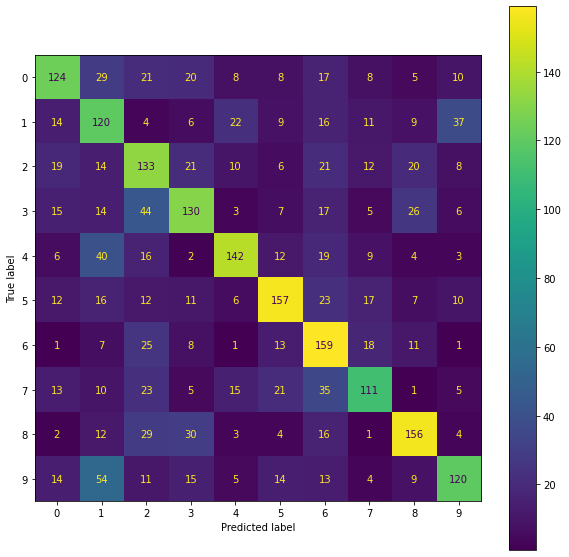

In [ ]:
# matriz de confusion
fig, ax = plt.subplots(figsize=(10, 10))
cm = plot_confusion_matrix(gnb, Xt, yt, ax=ax, values_format="d")

# resporte de metricas por clase
print(classification_report(yt, y_pred_gnb_test))

## 3.2 Random Forest

### Train model: Búsqueda de los hiperparámetros

In [ ]:
if run_full:
  parameters = {'n_estimators':range(10, 200, 5), 'max_depth':range(1,40)}
  score, params, rfc = search_hyperparameters(parameters, RandomForestClassifier)
else:
  # Este archivo contiene el modelo ya entrenado, nos evitamos entrenar en cada run para mejorar los tiempos
  # https://scikit-learn.org/stable/modules/model_persistence.html
  !wget "https://github.com/dikaoru/csv-aa/blob/master/random_forest.tar.gz?raw=true"
  !tar -xf random_forest.tar.gz?raw=true -C /content/



--2020-07-12 15:25:24--  https://github.com/dikaoru/csv-aa/blob/master/random_forest.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dikaoru/csv-aa/raw/master/random_forest.tar.gz [following]
--2020-07-12 15:25:25--  https://github.com/dikaoru/csv-aa/raw/master/random_forest.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dikaoru/csv-aa/master/random_forest.tar.gz [following]
--2020-07-12 15:25:25--  https://raw.githubusercontent.com/dikaoru/csv-aa/master/random_forest.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting resp

### Hiperparametros

In [ ]:
# Aca carga el modelo desde un archivo joblib
rfc_params = load('/content/random_forest.joblib')

# extraigo el modelo, parametros y score guardados en la busqueda de hiperparametros
rfc = rfc_params['model']
best_params = rfc_params['params']
rfc_score_validation = rfc_params['score']

print('Los parámetros que dan la mejor métrica son:', best_params)
print('El valor de la mejor métrica es:', rfc_score_validation)

Los parámetros que dan la mejor métrica son: {'n_estimators': 145, 'max_depth': 34, 'bootstrap': False}
El valor de la mejor métrica es: 0.7012830793905372


### Resultado de las métricas

In [ ]:
# evaluo sobre el dataset de training
y_pred_rfc_train = rfc.predict(Xtr)
rfc_score_training = metric(ytr,y_pred_rfc_train)

#Evaluo sobre el dataset de testing
y_pred_rfc_test = rfc.predict(Xt)
rfc_score_testing = metric(yt,y_pred_rfc_test)


#Resultado de las métricas
list_scores = [['Random Forest Training', rfc_score_training], 
               ['Random Forest Validation', rfc_score_validation],
               ['Random Forest Testing', rfc_score_testing]]

# dibujo una tabla con los valores de las metricas.
render_metric_table(list_scores)

            modelo            |  score  
------------------------------|---------
    Random Forest Training    |  1.000  
   Random Forest Validation   |  0.701  
    Random Forest Testing     |  0.679  


### Matriz de Confusión

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       250
           1       0.71      0.56      0.63       248
           2       0.62      0.56      0.59       264
           3       0.58      0.64      0.61       267
           4       0.76      0.74      0.75       253
           5       0.71      0.67      0.69       271
           6       0.74      0.75      0.74       244
           7       0.64      0.70      0.67       239
           8       0.72      0.82      0.77       257
           9       0.68      0.70      0.69       259

    accuracy                           0.68      2552
   macro avg       0.68      0.68      0.68      2552
weighted avg       0.68      0.68      0.68      2552



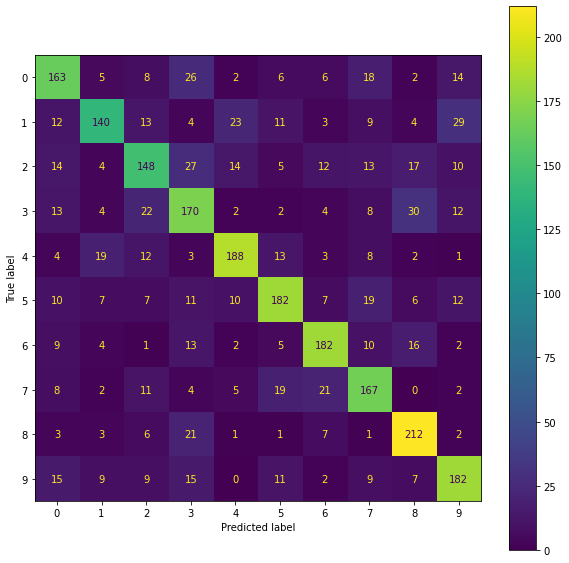

In [ ]:
# matriz de confusion
fig, ax = plt.subplots(figsize=(10, 10))
cm = plot_confusion_matrix(rfc, Xt, yt, ax=ax, values_format="d")

# resporte de metricas por clase
print(classification_report(yt, y_pred_rfc_test))

## 3.3 Gradient Boosting Classifier

### Train model: Búsqueda de los hiperparámetros

In [ ]:
parameters = parameters = {'n_estimators':range(10, 100, 5), 'max_depth':range(1,7), 'learning_rate':np.arange(0,1,0.01)}

if run_full:
  # la busqueda de hiperparametros tarda mas de 1hs.
  score, params, model = search_hyperparameters(parameters, GradientBoostingClassifier)
else:
  # Este archivo contiene el modelo ya entrenado, nos evitamos entrenar en cada run para mejorar los tiempos
  # https://scikit-learn.org/stable/modules/model_persistence.html
  !wget "https://github.com/dikaoru/csv-aa/blob/master/gradient_boosting.joblib?raw=true" -O /content/gradient_boosting.joblib

--2020-07-12 15:25:32--  https://github.com/dikaoru/csv-aa/blob/master/gradient_boosting.joblib?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dikaoru/csv-aa/raw/master/gradient_boosting.joblib [following]
--2020-07-12 15:25:33--  https://github.com/dikaoru/csv-aa/raw/master/gradient_boosting.joblib
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dikaoru/csv-aa/master/gradient_boosting.joblib [following]
--2020-07-12 15:25:33--  https://raw.githubusercontent.com/dikaoru/csv-aa/master/gradient_boosting.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request

### Hiperparametros

In [ ]:
gbc_params = load('/content/gradient_boosting.joblib')

# extraigo el modelo, parametros y score guardados en la busqueda de hiperparametros
gbc = gbc_params['model']
best_params = gbc_params['params']
gbc_score_validation = gbc_params['score']

print('Los parámetros que dan la mejor métrica son:', best_params)
print('El valor de la mejor métrica es:', gbc_score_validation)

Los parámetros que dan la mejor métrica son: {'n_estimators': 85, 'max_depth': 5, 'learning_rate': 0.26}
El valor de la mejor métrica es: 0.7305533279871692


### Resultado de las métricas

In [ ]:
# evaluo sobre el dataset de training
y_pred_gbc_train = gbc.predict(Xtr)
gbc_score_training = metric(ytr,y_pred_gbc_train)

#Evaluo sobre el dataset de testing
y_pred_gbc_test = gbc.predict(Xt)
gbc_score_testing = metric(yt,y_pred_gbc_test)


#Resultado de las métricas
list_scores = [['Gradient Boosting Training', gbc_score_training], 
               ['Gradient Boosting Validation', gbc_score_validation],
               ['Gradient Boosting Testing', gbc_score_testing]]

# dibujo una tabla con los valores de las metricas.
render_metric_table(list_scores)

            modelo            |  score  
------------------------------|---------
  Gradient Boosting Training  |  1.000  
 Gradient Boosting Validation |  0.731  
  Gradient Boosting Testing   |  0.719  


### Matriz de Confusión

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       250
           1       0.69      0.60      0.65       248
           2       0.65      0.66      0.65       264
           3       0.59      0.66      0.62       267
           4       0.80      0.73      0.76       253
           5       0.73      0.72      0.73       271
           6       0.83      0.77      0.80       244
           7       0.65      0.81      0.72       239
           8       0.81      0.80      0.81       257
           9       0.74      0.75      0.74       259

    accuracy                           0.72      2552
   macro avg       0.72      0.72      0.72      2552
weighted avg       0.72      0.72      0.72      2552



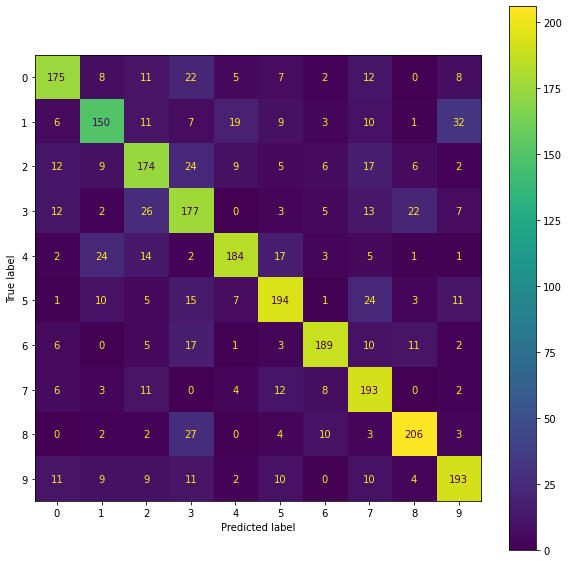

In [ ]:
# matriz de confusion
fig, ax = plt.subplots(figsize=(10, 10))
cm = plot_confusion_matrix(gbc, Xt, yt, ax=ax, values_format="d")


# resporte de metricas por clase
print(classification_report(yt, y_pred_gbc_test))

#Agregamos ruido 

## Declaración de las librerías

In [ ]:
import numpy as np

## Agregamos ruido Gaussiano


In [ ]:
# @title Nivel de ruido Gaussiano
nivel_de_ruido = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}

In [ ]:
# Función que agrega ruido gaussiano extrae valores desde una observación
def calculate_features_with_noise(filename,n_mfcc=12,
                                  delta=True,
                                  deltadelta=True,
                                  energy=True, 
                                  summary_fn = [np.mean, np.std], 
                                  summary_names=['mean','std']):
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  #Agregamos ruido gaussiano
  ruido = np.random.normal(size= x.shape) 
  x = x+ nivel_de_ruido*ruido
  
  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
  feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])
    feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
  feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
    d_names = ['d{}'.format(name) for name in feat_names]
  else:
    d_names = []

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
    dd_names = ['dd{}'.format(name) for name in feat_names]
  else:
    dd_names = []

  feat_names = feat_names + d_names + dd_names
  
  return summary_features, feat_names   

# funciones soporte
def generate_gaussiano_df(lista_testing):
  data = []
  columns = []

  for num_key, num_value  in NUMBERS.items():
    wavs = glob.glob('speechcommands/{0}/*.wav'.format(num_key))
    for path in wavs:
      if path in lista_testing:
        feature, names = calculate_features_with_noise(path)
        type = 'testing' 
        data.append(np.append(feature, [num_value, path, type]))
        columns = names + ['target', 'filename', 'type']

  dataset_con_ruido_gaussiano = pd.DataFrame(data, columns = columns)
  return dataset_con_ruido_gaussiano

In [ ]:
if run_full:
  #Generamos dataset de audios testing agregándole el nivel de ruido gaussiano elegido
  lista_testing = get_partition('speechcommands/testing_list.txt')
  df = generate_gaussiano_df(lista_testing)
  print(df.shape)
  df.to_csv('/content/speech_dataset_noise_gaussiano.csv', header=True, index=True) 
else:
  #Descargar el dataset creado
  # con 10% de ruido
  # url = 'https://raw.githubusercontent.com/dikaoru/csv-aa/master/speech_dataset_noise_gaussiano.csv'
 
  # con 1% de ruido
  url = 'https://raw.githubusercontent.com/dikaoru/csv-aa/master/speech_dataset_noise_gaussiano-uno_porciento.csv'
  df_ruido_gaussiano = pd.read_csv(url, index_col = 0)


In [ ]:
# #Leer el dataset creado
df_ruido_gaussiano_index = pd.Index(df_ruido_gaussiano)

df_ruido_gaussiano.head()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,...,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,filename,type
0,-174.075716,41.844807,17.463111,10.071919,-5.187013,-5.359340,-8.533012,-10.258925,-7.183099,-11.003183,-6.981214,-2.679599,0.072916,49.841767,38.235266,14.956589,24.563090,9.106524,9.691546,6.632994,9.400091,8.636559,10.835486,9.605474,6.003190,0.062541,0.407503,0.108672,0.054477,-0.039830,0.288120,0.171018,-0.015520,0.105458,0.129377,0.095984,-0.009042,0.204925,0.000014,13.190601,...,8.552180,10.052874,4.611713,5.359056,4.227121,4.585492,5.073257,5.073996,4.107831,3.747002,0.015262,-0.334580,-0.106681,0.007459,0.064310,0.076589,-0.304223,-0.066232,0.056327,-0.004076,-0.157969,0.019774,-0.010747,-3.990151e-06,11.590923,7.607215,8.964826,7.705209,4.507725,6.333088,5.218690,5.396834,6.285350,6.191852,4.795314,5.073644,0.008826,0,speechcommands/zero/b49caed3_nohash_2.wav,testing
1,-169.598177,28.422459,-0.403664,5.808889,-3.813839,-10.051776,-5.853915,0.568369,-1.818283,-8.031500,-4.686170,-0.624635,0.079657,49.984332,31.477898,23.005839,18.832397,16.418858,12.554665,11.197003,5.544304,8.647829,7.242653,7.008711,5.026672,0.064204,0.207108,-0.047140,0.050662,0.022778,-0.271470,0.095882,-0.118973,-0.291004,0.140211,-0.096711,-0.041261,-0.225630,0.000063,14.375274,...,11.825906,9.586761,10.064854,5.882552,4.101097,3.342230,5.678517,5.131530,5.256777,4.407512,0.016869,-0.243855,-0.143223,0.111391,0.140765,-0.120013,-0.236786,-0.138507,0.156020,0.167725,0.119610,-0.006231,0.152915,-8.555028e-07,10.765270,14.638243,11.118448,9.293554,7.927246,6.719861,3.783157,4.372199,6.348371,6.214816,6.111810,5.518065,0.011241,0,speechcommands/zero/692a88e6_nohash_1.wav,testing
2,-177.403256,38.484463,15.321739,10.198242,7.184030,2.716945,-3.612466,-0.535526,-5.236866,-3.652774,0.917914,4.236562,0.050030,46.084851,34.951367,13.386557,16.205566,8.620254,10.326468,12.503783,12.749181,9.285499,7.849636,7.931860,5.599593,0.038141,0.240767,0.442802,0.035033,-0.061998,-0.033411,0.087932,0.234739,-0.097756,0.026396,-0.309874,-0.109711,-0.165514,-0.000004,13.106443,...,9.012376,9.183590,5.941616,5.671354,5.804888,6.257966,4.586550,4.906105,4.187475,3.862474,0.008900,-0.431453,-0.158280,0.212671,0.052260,-0.068991,-0.061159,0.144227,0.286337,0.160756,0.190191,0.086306,-0.235498,-8.728384e-06,10.283904,10.326768,8.690379,9.142140,7.309051,5.385773,6.705637,6.527564,5.093358,5.685013,4.320283,4.915650,0.004703,0,speechcommands/zero/0fa1e7a9_nohash_0.wav,testing
3,-211.780761,18.170034,10.575717,7.080615,4.549054,-1.692948,-6.724867,-7.305584,-6.517397,-6.495293,-5.910421,-3.303720,0.019635,24.851172,20.905131,9.230220,10.496262,9.338551,5.469205,9.648075,9.723822,6.648126,7.493551,7.571265,4.664169,0.014396,0.032213,0.216121,0.368943,0.386044,0.614128,0.343658,0.463551,0.530409,0.443199,0.322244,-0.023277,-0.017712,0.000106,7.998691,...,5.824456,5.931848,6.009548,4.803097,4.545984,4.633726,4.574267,3.760280,4.165727,4.286740,0.005213,-0.584694,-0.255788,0.193092,-0.157318,-0.172405,-0.180221,0.102794,0.121901,0.218820,0.166453,0.062475,0.143062,-3.149213e-05,6.890139,6.621045

###Correr modelos optimizados en testing con ruido gaussiano


In [ ]:
# defino los datasets
Xga, yga = df_ruido_gaussiano.iloc[:,1:78], df_ruido_gaussiano.iloc[:,78]


#### Naive Bayes

              precision    recall  f1-score   support

           0       0.57      0.02      0.03       250
           1       0.45      0.16      0.23       248
           2       0.13      0.89      0.22       264
           3       0.33      0.01      0.02       267
           4       0.34      0.28      0.31       253
           5       0.66      0.19      0.30       271
           6       1.00      0.03      0.06       244
           7       0.56      0.02      0.04       239
           8       0.26      0.27      0.27       257
           9       1.00      0.01      0.02       259

    accuracy                           0.19      2552
   macro avg       0.53      0.19      0.15      2552
weighted avg       0.53      0.19      0.15      2552



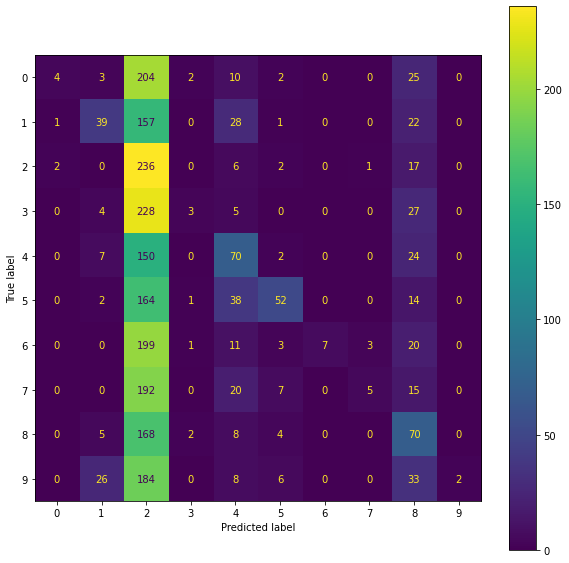

In [ ]:
#Evaluo sobre el dataset de testing
y_pred_gnb_gaussiano = gnb.predict(Xga)
gnb_score_gaussiano = metric(yga,y_pred_gnb_gaussiano)

# matriz de confusion
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gnb, Xga, yga, ax=ax, values_format="d")

# resporte de metricas por clase
print(classification_report(yga, y_pred_gnb_gaussiano))

#### Random Forest

              precision    recall  f1-score   support

           0       0.46      0.32      0.38       250
           1       0.51      0.47      0.49       248
           2       0.29      0.40      0.34       264
           3       0.36      0.09      0.15       267
           4       0.44      0.66      0.53       253
           5       0.95      0.21      0.34       271
           6       0.24      0.66      0.36       244
           7       0.61      0.32      0.42       239
           8       0.49      0.54      0.51       257
           9       0.44      0.36      0.39       259

    accuracy                           0.40      2552
   macro avg       0.48      0.40      0.39      2552
weighted avg       0.48      0.40      0.39      2552



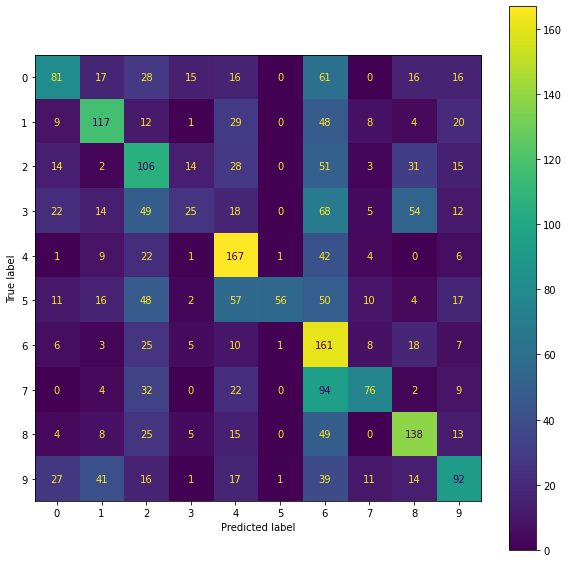

In [ ]:
# matriz de confusion
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rfc, Xga, yga, ax=ax, values_format="d")

#Evaluo sobre el dataset de testing
y_pred_rfc_gaussiano = rfc.predict(Xga)
rfc_score_gaussiano = metric(yga,y_pred_rfc_gaussiano)

# resporte de metricas por clase
print(classification_report(yga, y_pred_rfc_gaussiano))

#### Gradient Boosting Classifier

              precision    recall  f1-score   support

           0       0.45      0.40      0.42       250
           1       0.54      0.57      0.56       248
           2       0.32      0.40      0.36       264
           3       0.50      0.19      0.28       267
           4       0.44      0.62      0.52       253
           5       0.59      0.36      0.44       271
           6       0.31      0.60      0.41       244
           7       0.34      0.45      0.39       239
           8       0.63      0.51      0.56       257
           9       0.70      0.33      0.45       259

    accuracy                           0.44      2552
   macro avg       0.48      0.44      0.44      2552
weighted avg       0.48      0.44      0.44      2552



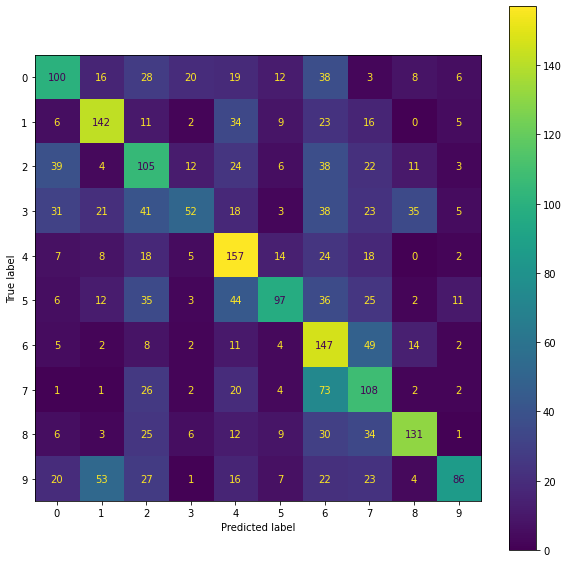

In [ ]:
# matriz de confusion
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gbc, Xga, yga, ax=ax, values_format="d")

#Evaluo sobre el dataset de testing
y_pred_gbc_gaussiano = gbc.predict(Xga)
gbc_score_gaussiano = metric(yga,y_pred_gbc_gaussiano)

# resporte de metricas por clase
print(classification_report(yga, y_pred_gbc_gaussiano))

##Agregamos ruido ambiente (dishes)

In [ ]:
#@title Nivel de ruido ambiente
nivel_de_ruido_ambiente = 0.1 #@param {type:"slider", min:0, max:3, step:0.1}

In [ ]:
# Función que agrega ruido ambiente y extrae valores desde una observación 

def calculate_features_with_noise_ambient(filename,n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
  x, sr = librosa.core.load(filename, sr=None)
  
  #Ruido ambiente al 10%
  ruido_audio, sr = librosa.core.load('speechcommands/_background_noise_/doing_the_dishes.wav', sr=None)
  ruido_audio = ruido_audio[5000:5000+len(x)] #Lo recorto para que tenga la longitud del audio
  x = x + nivel_de_ruido_ambiente*ruido_audio
  
  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
  feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])
    feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
  feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
    d_names = ['d{}'.format(name) for name in feat_names]
  else:
    d_names = []

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
    dd_names = ['dd{}'.format(name) for name in feat_names]
  else:
    dd_names = []

  feat_names = feat_names + d_names + dd_names
  
  return summary_features, feat_names   

# funciones soporte

def generate_ambient_df(lista_testing_noise_ambient):
  data = []
  columns = []

  for num_key, num_value  in NUMBERS.items():
    wavs = glob.glob('speechcommands/{0}/*.wav'.format(num_key))
    for path in wavs:
      if path in lista_testing:
        feature, names = calculate_features_with_noise_ambient(path)
        type = 'testing' 
        data.append(np.append(feature, [num_value, path, type]))
        columns = names + ['target', 'filename', 'type']

  dataset_con_ruido_ambiente = pd.DataFrame(data, columns = columns)
  return dataset_con_ruido_ambiente


In [ ]:
if run_full:
  #Calculamos valores y generamos un dataset de los audios con ruido ambiente
  lista_testing_noise_ambient = get_partition('speechcommands/testing_list.txt')
  df = generate_ambient_df(lista_testing_noise_ambient)
  print(df.shape)
  df.to_csv('/content/speech_dataset_noise_ambient.csv', header=True, index=True) 
else:
  #Descargar el dataset creado
  url = 'https://raw.githubusercontent.com/dikaoru/csv-aa/master/speech_dataset_noise_ambient.csv'
  df_ruido_ambiente = pd.read_csv(url, index_col = 0)

In [ ]:
# #Leer el dataset creado
print(df_ruido_ambiente.shape)

df_ruido_ambiente.head()

(2552, 81)


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,...,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,filename,type
0,-231.160964,102.122939,8.799892,36.892218,26.490501,17.282831,-2.079858,4.885514,2.365780,15.360709,7.435339,7.453295,0.076850,73.643781,26.251786,32.794552,16.467708,12.895494,12.070532,19.121112,11.065903,11.199898,9.468020,6.922144,8.734191,0.040098,-0.004909,0.118330,0.294979,-0.072731,0.254492,0.187779,0.024624,0.208025,0.269120,0.172212,0.104019,0.015619,0.000673,23.277370,...,15.024792,10.666570,9.585200,5.618375,7.925637,5.346674,7.456145,5.625217,5.344804,5.759164,0.011106,-0.397316,-0.190076,0.186059,-0.027932,-0.162521,0.009647,-0.037852,-0.171478,-0.132427,-0.228126,-0.255542,-0.050190,-0.000223,18.755972,7.583290,13.529903,10.652272,10.149718,5.921200,6.136916,5.557097,7.753866,5.974421,7.183054,6.593419,0.008248,0,speechcommands/zero/6021f08b_nohash_0.wav,testing
1,-226.632715,72.906819,-12.983918,27.665616,2.163799,-6.361834,-13.362360,5.335331,-1.876942,0.267176,1.625088,5.097813,0.057881,84.134269,33.426742,35.973692,26.387157,17.520682,15.859495,10.205082,4.266648,12.452184,10.274470,8.170876,10.657134,0.051699,0.439429,1.241448,-0.210667,0.262984,0.450350,0.198243,0.224726,-0.099397,0.234643,-0.294504,-0.195303,-0.239017,0.000202,23.067713,...,12.549988,13.982228,10.373075,7.870573,5.534291,3.727923,5.682499,5.465364,5.090951,6.071922,0.015846,-0.984435,-0.854873,-0.128816,0.044004,0.166247,0.212069,-0.047727,-0.201824,0.001825,-0.031827,0.138288,0.500440,-0.000354,16.471000,13.790482,9.720039,12.628419,9.743204,8.158772,6.065978,4.301605,5.949601,6.541952,6.156682,6.021640,0.011175,0,speechcommands/zero/9a356ab9_nohash_0.wav,testing
2,-275.736547,81.140518,-31.678485,8.192047,-8.050540,-13.020994,-18.425047,-13.742564,-12.078471,-11.741452,4.020150,6.066708,0.050165,76.450633,46.913896,25.957282,24.905421,12.130072,11.692064,11.890243,6.355213,10.060207,16.333594,7.750344,9.072346,0.054522,0.281933,0.171861,0.049580,-0.098732,0.138746,0.281918,0.111843,0.290220,0.324313,0.172042,0.107208,0.023954,-0.000003,18.702750,...,12.558461,11.805291,7.417775,6.512207,6.018384,3.262841,5.516115,7.591983,5.994602,5.150718,0.014187,-0.409180,-0.338278,0.012349,0.059250,-0.094228,0.117583,0.106586,-0.095065,0.103764,-0.122514,-0.037074,0.250533,-0.000003,13.335440,7.958702,9.623671,9.860872,7.108913,7.249074,6.949983,3.635971,6.122364,7.556115,6.610998,5.123324,0.010048,0,speechcommands/zero/ffa76c4a_nohash_0.wav,testing
3,-296.152807,71.252755,-24.752297,-1.291706,2.582055,-13.033137,-15.970519,-5.492801,-4.710007,2.712824,-0.229066,3.456209,0.020860,48.886287,41.325680,21.318481,12.061560,10.515198,9.544229,8.830929,5.915584,10.408056,7.335370,7.195736,9.615434,0.019713,0.109133,-0.039675,-0.236697,-0.280898,-0.061717,-0.034671,-0.191785,-0.077639,0.036767,-0.183297,-0.109700,-0.114952,-0.000001,13.611988,...,13.588197,9.982348,5.721688,5.782709,4.912296,4.797795,7.239057,5.382060,4.907939,4.609772,0.005283,-0.163656,-0.093450,0.174040,0.095907,-0.042282,0.252549,0.265845,-0.007660,0.066795,-0.217256,-0.122534,0.208651,-0.000001,11.867

### Evaluamos en los audios de testing con ruido ambiente

In [ ]:
# defino los datasets
Xamb, yamb = df_ruido_ambiente.iloc[:,1:78], df_ruido_ambiente.iloc[:,78]

#### Naive Bayes

              precision    recall  f1-score   support

           0       0.61      0.16      0.26       250
           1       0.34      0.57      0.42       248
           2       0.23      0.75      0.35       264
           3       0.36      0.16      0.22       267
           4       0.43      0.58      0.49       253
           5       0.40      0.70      0.51       271
           6       0.87      0.16      0.28       244
           7       0.53      0.15      0.23       239
           8       0.40      0.14      0.20       257
           9       0.47      0.13      0.20       259

    accuracy                           0.36      2552
   macro avg       0.46      0.35      0.32      2552
weighted avg       0.46      0.36      0.32      2552



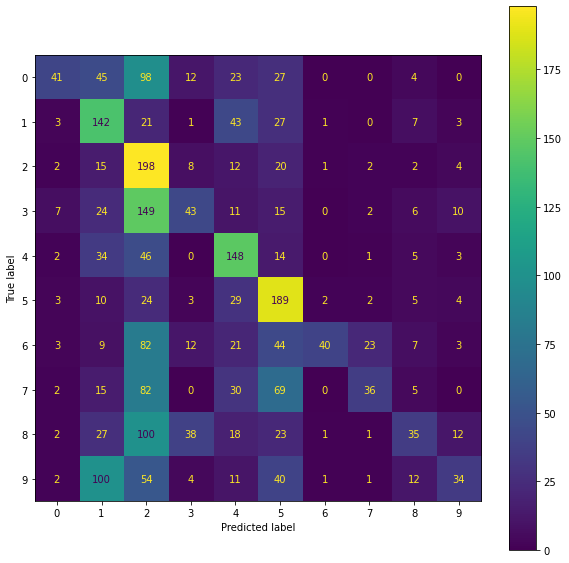

In [ ]:
# matriz de confusion
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gnb, Xamb, yamb, ax=ax, values_format="d")

#Evaluo sobre el dataset de testing
y_pred_gnb_ambiente = gnb.predict(Xamb)
gnb_score_ambiente = metric(yamb,y_pred_gnb_ambiente)

# resporte de metricas por clase
print(classification_report(yamb, y_pred_gnb_ambiente))

#### Random Forest

              precision    recall  f1-score   support

           0       0.55      0.63      0.59       250
           1       0.49      0.50      0.50       248
           2       0.42      0.62      0.50       264
           3       0.54      0.37      0.44       267
           4       0.59      0.71      0.65       253
           5       0.63      0.64      0.63       271
           6       0.90      0.58      0.70       244
           7       0.71      0.48      0.57       239
           8       0.66      0.68      0.67       257
           9       0.51      0.54      0.53       259

    accuracy                           0.58      2552
   macro avg       0.60      0.58      0.58      2552
weighted avg       0.60      0.58      0.58      2552



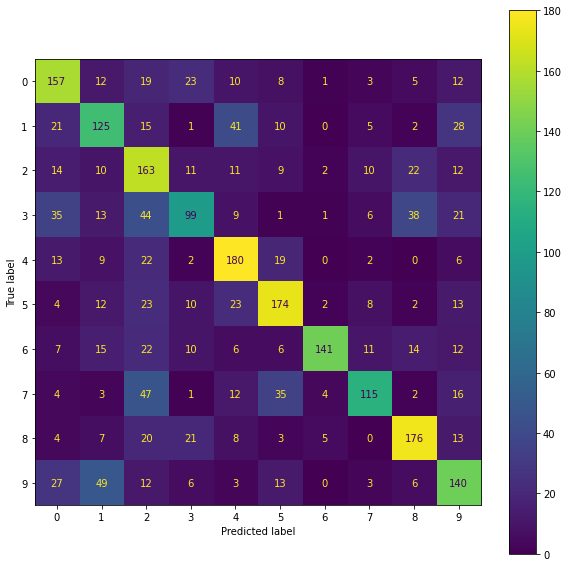

In [ ]:
# matriz de confusion
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rfc, Xamb, yamb, ax=ax, values_format="d")

#Evaluo sobre el dataset de testing
y_pred_rfc_ambiente = rfc.predict(Xamb)
rfc_score_ambiente = metric(yamb,y_pred_rfc_ambiente)

# resporte de metricas por clase
print(classification_report(yamb, y_pred_rfc_ambiente))

#### Gradient Boosting Classifier

              precision    recall  f1-score   support

           0       0.45      0.40      0.42       250
           1       0.54      0.57      0.56       248
           2       0.32      0.40      0.36       264
           3       0.50      0.19      0.28       267
           4       0.44      0.62      0.52       253
           5       0.59      0.36      0.44       271
           6       0.31      0.60      0.41       244
           7       0.34      0.45      0.39       239
           8       0.63      0.51      0.56       257
           9       0.70      0.33      0.45       259

    accuracy                           0.44      2552
   macro avg       0.48      0.44      0.44      2552
weighted avg       0.48      0.44      0.44      2552



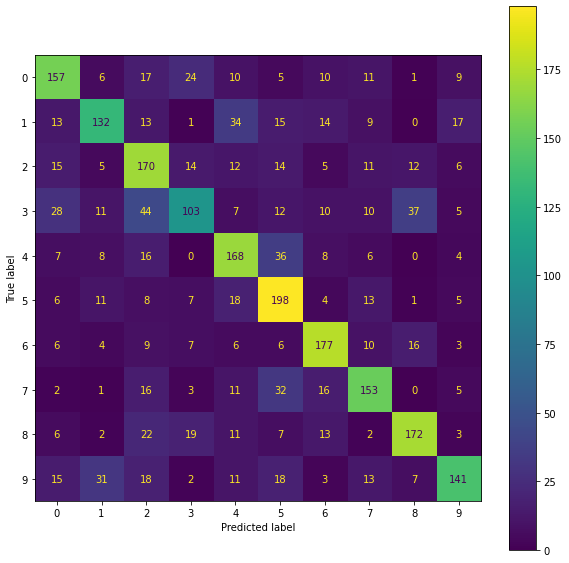

In [ ]:
# matriz de confusion
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gbc, Xamb, yamb, ax=ax, values_format="d")

#Evaluo sobre el dataset de testing
y_pred_gbc_ambiente = gbc.predict(Xga)
gbc_score_ambiente = metric(yamb,y_pred_gbc_ambiente)

# resporte de metricas por clase
print(classification_report(yamb, y_pred_gbc_ambiente))

In [ ]:
#Resultado de las métricas
list_scores = [['Naive Bayes ', gnb_score_ambiente], 
               ['Random Forest ', rfc_score_ambiente],
               ['Gradient Boosting ', gbc_score_ambiente]]

# dibujo una tabla con los valores de las metricas.
render_metric_table(list_scores)

            modelo            |  score  
------------------------------|---------
         Naive Bayes          |  0.355  
        Random Forest         |  0.576  
      Gradient Boosting       |  0.441  


# Audios Grabados

In [ ]:
#Descargar el dataset creado
url = 'https://raw.githubusercontent.com/dikaoru/csv-aa/master/speech_alto.csv'
df_grab_bajo = pd.read_csv(url, index_col = 0)

url = 'https://raw.githubusercontent.com/dikaoru/csv-aa/master/bajo.csv'
df_grab_alto = pd.read_csv(url, index_col = 0)

url = 'https://raw.githubusercontent.com/dikaoru/csv-aa/master/phaser.csv'
df_grab_phaser = pd.read_csv(url, index_col = 0)

url = 'https://raw.githubusercontent.com/dikaoru/csv-aa/master/reverb.csv'
df_grab_reverb = pd.read_csv(url, index_col = 0)

url = 'https://raw.githubusercontent.com/dikaoru/csv-aa/master/original.csv'
df_grab_original = pd.read_csv(url, index_col = 0)

print('alto', df_grab_alto.shape)
print('bajo', df_grab_bajo.shape)
print('phaser', df_grab_phaser.shape)
print('reverb', df_grab_reverb.shape)
print('original', df_grab_original.shape)


alto (36, 81)
bajo (36, 81)
phaser (36, 81)
reverb (36, 81)
original (36, 81)


## Evaluamos en los audios grabados

In [ ]:
# defino los datasets
Xalto, yalto = df_grab_alto.iloc[:,1:78], df_grab_alto.iloc[:,78]
Xbajo, ybajo = df_grab_bajo.iloc[:,1:78], df_grab_bajo.iloc[:,78]
Xphaser, yphaser = df_grab_phaser.iloc[:,1:78], df_grab_phaser.iloc[:,78]
Xreverb, yreverb = df_grab_reverb.iloc[:,1:78], df_grab_reverb.iloc[:,78]
Xoriginal, yoriginal = df_grab_original.iloc[:,1:78], df_grab_original.iloc[:,78]

In [ ]:
def get_scores(X, y):
  y_pred_bayes = gnb.predict(X)
  score_bayes = metric(y,y_pred_bayes)

  y_pred_forest = rfc.predict(X)
  score_forest = metric(y,y_pred_forest)

  y_pred_boosting = gbc.predict(X)
  score_boosting = metric(y,y_pred_boosting)

  return score_bayes, score_forest, score_boosting

score_bayes_alto, score_forest_alto, score_boosting_alto = get_scores(Xalto, yalto)
score_bayes_bajos, score_forest_bajos, score_boosting_bajos = get_scores(Xbajo, ybajo)
score_bayes_phaser, score_forest_phaser, score_boosting_phaser = get_scores(Xphaser, yphaser)
score_bayes_reverb, score_forest_reverb, score_boosting_reverb = get_scores(Xreverb, yreverb)
score_bayes_original, score_forest_original, score_boosting_original = get_scores(Xoriginal, yoriginal)


#Resultado de las métricas
list_scores = [['Bayes original', score_bayes_original], 
               ['Forest original', score_forest_original],
               ['Boosting original', score_boosting_original],
               [],
               ['Bayes altos', score_bayes_alto], 
               ['Forest altos', score_forest_alto],
               ['Boosting altos', score_boosting_alto],
               [],
               ['Bayes bajos', score_bayes_bajos], 
               ['Forest bajos', score_forest_bajos],
               ['Boosting bajos', score_boosting_bajos],
               [],
               ['Bayes phaser', score_bayes_phaser], 
               ['Forest phaser', score_forest_phaser],
               ['Boosting phaser', score_boosting_phaser],
               [],
               ['Bayes reverb', score_bayes_reverb], 
               ['Forest reverb', score_forest_reverb],
               ['Boosting reverb', score_boosting_reverb]
               ]
# dibujo una tabla con los valores de las metricas.
render_metric_table(list_scores)

            modelo            |  score  
------------------------------|---------
        Bayes original        |  0.278  
       Forest original        |  0.278  
      Boosting original       |  0.306  
---------------------------------------
         Bayes altos          |  0.306  
         Forest altos         |  0.278  
        Boosting altos        |  0.250  
---------------------------------------
         Bayes bajos          |  0.194  
         Forest bajos         |  0.056  
        Boosting bajos        |  0.222  
---------------------------------------
         Bayes phaser         |  0.194  
        Forest phaser         |  0.222  
       Boosting phaser        |  0.278  
---------------------------------------
         Bayes reverb         |  0.194  
        Forest reverb         |  0.222  
       Boosting reverb        |  0.194  


# Graficos

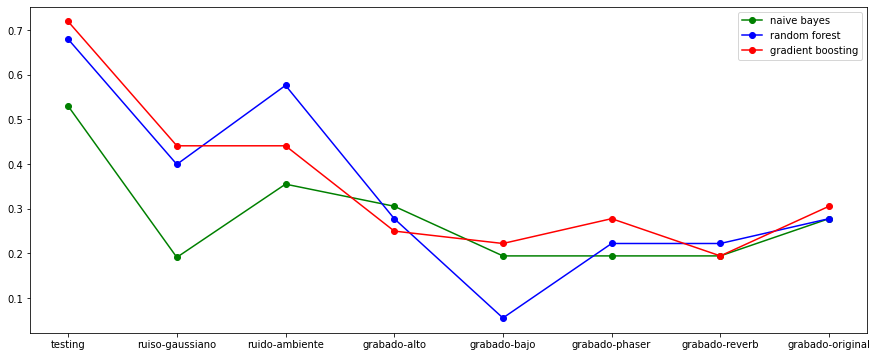

In [ ]:
label = ['testing', 'ruiso-gaussiano', 'ruido-ambiente', 'grabado-alto', 'grabado-bajo', 'grabado-phaser', 'grabado-reverb', 'grabado-original']
bayes = [gnb_score_testing, gnb_score_gaussiano, gnb_score_ambiente, score_bayes_alto, score_bayes_bajos, score_bayes_phaser, score_bayes_reverb, score_bayes_original]
forest = [rfc_score_testing, rfc_score_gaussiano, rfc_score_ambiente, score_forest_alto, score_forest_bajos, score_forest_phaser, score_forest_reverb, score_forest_original]
boosting = [gbc_score_testing, gbc_score_gaussiano, gbc_score_ambiente, score_boosting_alto, score_boosting_bajos, score_boosting_phaser, score_boosting_reverb, score_boosting_original]

x_pos = [i for i, _ in enumerate(label)]

plt.subplots(figsize=(15, 6))
plt.plot(x_pos, bayes,'-o', color='green', label="naive bayes")
plt.plot(x_pos, forest, '-o', color='blue', label="random forest")
plt.plot(x_pos, boosting,'-o', color='red', label="gradient boosting")

plt.xticks(x_pos, label)
plt.legend()
plt.show()